### REINFORCE to solve MountainCar

In [14]:
import os

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [15]:
import random
import os
import gc
import typing as tp
import numpy as np
import torch


NUM_THREADS = 10
SEED = 123


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def _init_fn(worker_id):
    np.random.seed(SEED + worker_id)

def preset():
    seed_everything(SEED)
    torch.cuda.empty_cache()
    gc.collect()
    
seed_everything(SEED)

In [16]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [17]:
env = gym.make('MountainCar-v0').env
env.reset()

#plt.imshow(env.render('rgb_array'))
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action space: Discrete(3)


In [18]:
def make_env(env_name: str):
    return gym.make(env_name).env


In [19]:
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, env.action_space.n),
)

optimizer = torch.optim.Adam(model.parameters())

In [20]:
type(optimizer)

torch.optim.adam.Adam

In [21]:
isinstance(optimizer, nn.Module)

False

In [22]:
from tqdm.notebook import trange
from IPython.display import clear_output


class REINFORCE:
    def __init__(
        self,
        env_name, 
        model,
        optimizer,
        *,
        entropy_threshold=1e-2,
        gamma=0.99,
        t_max=10**4,
    ):
        self.env = make_env(env_name)
        self.n_actions = env.action_space.n
        self.states_dim = env.observation_space.shape
        self.model = model
        self.optimizer = optimizer
        self.gamma = gamma
        self.entropy_threshold = entropy_threshold
        self.t_max = t_max
        
    def get_action(self, states):
        with torch.no_grad():
            logits = self.model(torch.FloatTensor(states))

        action_probs = F.softmax(logits, dim=-1).numpy()
        
        return np.random.choice(self.n_actions, p=action_probs)
    
    def generate_session(self):
        states, actions, rewards = [], [], []
        s = self.env.reset()

        for t in range(self.t_max):
            a = self.get_action(s)
            new_s, r, done, _ = self.env.step(a)

            states.append(s)
            actions.append(a)
            rewards.append(r)

            s = new_s
            if done:
                break

        return states, actions, rewards

    def get_cumulative_rewards(self, rewards):
        gts = []
        for reward in rewards[::-1]:
            gts.append(reward  + self.gamma * (gts[-1] if gts else 0))
        return gts[::-1]
    
    @staticmethod
    def to_one_hot(y_tensor, ndims):
        """ helper: take an integer vector and convert it to 1-hot matrix. """
        y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
        y_one_hot = torch.zeros(
            y_tensor.size()[0], 
            ndims,
        ).scatter_(1, y_tensor, 1)
        return y_one_hot
    
    def fit(self, states, actions, rewards):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        
        cumulative_returns = torch.tensor(
            self.get_cumulative_rewards(rewards),
            dtype=torch.float32,
        )

        logits = self.model(states)
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)

        log_probs_for_actions = torch.sum(
            log_probs * self.to_one_hot(actions, self.n_actions), 
            dim=1,
        )

        entropy = -self.entropy_threshold * (probs * log_probs).sum(dim=-1).mean()
        loss = -((log_probs_for_actions * cumulative_returns).mean() + entropy)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return np.sum(rewards)
    
    def train(
        self,
        *,
        num_epochs=100, 
        n_sessions=20, 
        win_threshold=-150,
    ):
        total_rewards = []
        
        for epoch in range(num_epochs):
            rewards = [self.fit(*self.generate_session()) for _ in trange(n_sessions)] 
            
            total_reward = np.mean(rewards)
            total_rewards.append(total_reward)
            
            clear_output(True)
            print(f'Epoch = {epoch}')
            plt.plot(total_rewards, label='total_reward')
            plt.legend()
            plt.grid()
            plt.show()

            if total_reward > win_threshold:
                print('You Win!')
                break
    

In [23]:
agent = REINFORCE(
    'MountainCar-v0',
    model,
    optimizer,
)

Epoch = 14


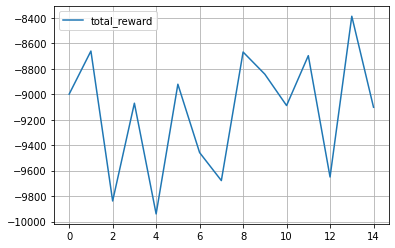

KeyboardInterrupt: 

In [24]:
agent.train()